# Urbansed

In [3]:
# Automatically reload modules before entering the execution of code typed at 
# the IPython prompt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Import used libraries
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import librosa
import torch

torch.manual_seed(0)

print(f"{pd.__name__} version: {pd.__version__}")
print(f"{matplotlib.__name__} version: {matplotlib.__version__}")
print(f"{librosa.__name__} version: {librosa.__version__}")
print(f"{torch.__name__} version: {torch.__version__}")

pandas version: 2.1.2
matplotlib version: 3.8.3
librosa version: 0.10.2.post1
torch version: 2.4.0


In [5]:
from yoho.utils import AudioFile

def plot_melspectrogram(
    audio: AudioFile,
    n_mels: int = 40,
    win_len: float = 0.04,
    hop_len: float = 0.01,
):
    """
    Plots the Mel spectrogram.
    """
    plt.figure(figsize=(10, 4))
    plt.title(f"Mel spectrogram")
    librosa.display.specshow(
        data=audio.mel_spectrogram(
            n_mels=n_mels, win_len=win_len, hop_len=hop_len
        ),
        sr=audio.sr,
        hop_length=hop_len*audio.sr,
        x_axis="s",
        y_axis="mel",
    )
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

## TUT Dataset

In [6]:
from yoho.train import load_dataset
from yoho.utils import UrbanSEDDataset

urbansed_train: UrbanSEDDataset = load_dataset(partition="train")
urbansed_val: UrbanSEDDataset = load_dataset(partition="validate")

print(f"Number of audio clips in the train dataset: {len(urbansed_train)}")
print(f"Number of audio clips in the validation dataset: {len(urbansed_val)}")
print(f"Duration of each audio clips: {urbansed_train.audios[0].duration} seconds")
print(f"Sampling rate of each audio clips: {urbansed_train.audios[0].sr} Hz")

INFO:root:Loading the train dataset from the pickle file
INFO:root:Loading the validation dataset from the pickle file


Number of audio clips in the train dataset: 54000
Number of audio clips in the validation dataset: 18000
Duration of each audio clips: 2.56 seconds
Sampling rate of each audio clips: 44100 Hz


## Data generator

In [7]:
from yoho.utils import YOHODataGenerator

val_dataloader = YOHODataGenerator(
    urbansed_val, batch_size=32, shuffle=True
)

val_features, val_labels = next(iter(val_dataloader))

print(f"Test features shape: {val_features.shape}")
print(f"Test labels shape: {val_labels.shape}")

Test features shape: torch.Size([32, 1, 40, 257])
Test labels shape: torch.Size([32, 33, 9])


## YOHO model

In [8]:
from torchsummary import summary

from yoho.models import YOHO
from yoho.train import get_device

# Get the available device (cuda, mps or cpu)
device = get_device()

# Define the model
urbansed_model = YOHO(
    name="UrbanSEDYOHO",
    input_shape=(1, 40, 257), n_classes=len(urbansed_train.labels)
).to(device)

urbansed_model.load(f"./models/{urbansed_model.name}_checkpoint.pth.tar", device)

summary(
    urbansed_model,
    input_size=(1, 40, 257),
    batch_size=32,
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 32, 20, 129]             288
       BatchNorm2d-2          [32, 32, 20, 129]              64
              ReLU-3          [32, 32, 20, 129]               0
            Conv2d-4          [32, 32, 20, 129]             288
       BatchNorm2d-5          [32, 32, 20, 129]              64
              ReLU-6          [32, 32, 20, 129]               0
            Conv2d-7          [32, 64, 20, 129]           2,112
       BatchNorm2d-8          [32, 64, 20, 129]             128
              ReLU-9          [32, 64, 20, 129]               0
        Dropout2d-10          [32, 64, 20, 129]               0
DepthwiseSeparableConv-11          [32, 64, 20, 129]               0
           Conv2d-12           [32, 64, 10, 65]             576
      BatchNorm2d-13           [32, 64, 10, 65]             128
             ReLU-14           [32

## Evaluation

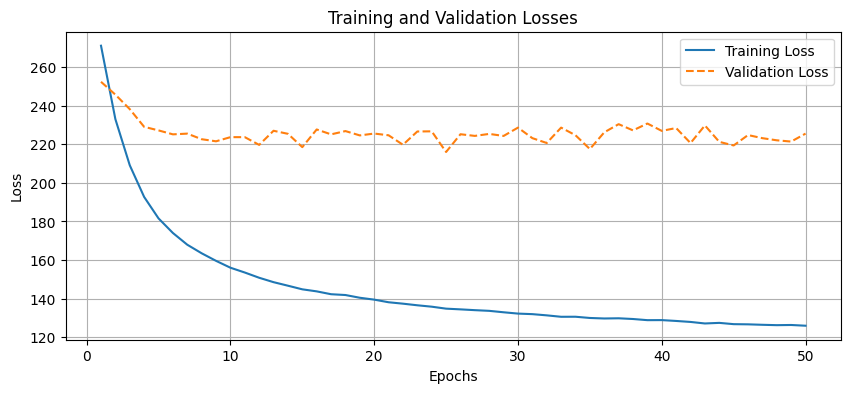

In [9]:
import json
import matplotlib.pyplot as plt

# Path to the losses.json file:

# Load the losses.json file
with open("./models/UrbanSEDYOHO_losses.json", "r") as f:
    losses = json.load(f)

# Extract epochs, train_loss, and val_loss
epochs = []
train_losses = []
val_losses = []

for epoch, metrics in losses.items():
    epochs.append(int(epoch))
    train_losses.append(metrics["train_loss"])
    val_losses.append(metrics["val_loss"])

# Sort the data by epochs to ensure correct plotting
epochs, train_losses, val_losses = zip(
    *sorted(zip(epochs, train_losses, val_losses))
)


# Plot the training and validation losses
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
prediction = urbansed_model(val_features.__getitem__(11).unsqueeze(0).to(device))
target = urbansed_val._get_output(11)
# Add the batch dimension to the target which is a numpy array
target = torch.from_numpy(target).unsqueeze(0).to(device)

In [26]:
import numpy as np

labels_ = [
    "noise",
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]


def process_output(output: np.array) -> list[tuple[str, float, float]]:

    STEPS_NO = 9
    step_duration = 2.56 / STEPS_NO
    MIN_EVENT_DURATION = 0
    MIN_SILENCE_DURATION = 1.0

    labels = []
    for i in range(output.shape[1]):

        for j in range(0, output.shape[0], 3):
            if output[j, i] >= 0.5:
                label = labels_[j // 3]
                start = (
                    i * step_duration + output[j + 1, i].item() * step_duration
                )
                end = (
                    i * step_duration + output[j + 2, i].item() * step_duration
                )
                labels.append((label, round(start, 2), round(end, 2)))

    # Order the labels by class
    labels = sorted(labels, key=lambda x: x[0])

    # Merge events of the same class that are close to each other
    merged_labels = []
    for label, start, end in labels:
        if not merged_labels:
            merged_labels.append((label, start, end))
        else:
            prev_label, prev_start, prev_end = merged_labels[-1]
            if prev_label == label and start - prev_end < MIN_SILENCE_DURATION:
                merged_labels[-1] = (label, prev_start, end)
            else:
                merged_labels.append((label, start, end))

    # Remove events that are too short
    merged_labels = [
        (label, start, end)
        for label, start, end in merged_labels
        if end - start >= MIN_EVENT_DURATION
    ]

    # Order the labels by start time
    # If two events start at the same time, order by class index
    merged_labels = sorted(
        merged_labels, key=lambda x: (x[1], labels_.index(x[0]))
    )

    return merged_labels


print(process_output(target[0]), process_output(prediction[0]), sep="\n")

[('noise', 0.0, 2.56), ('dog_bark', 0.0, 0.52), ('jackhammer', 2.37, 2.56)]
[('noise', 0.0, 2.56), ('siren', 0.0, 0.48), ('car_horn', 2.15, 2.56)]


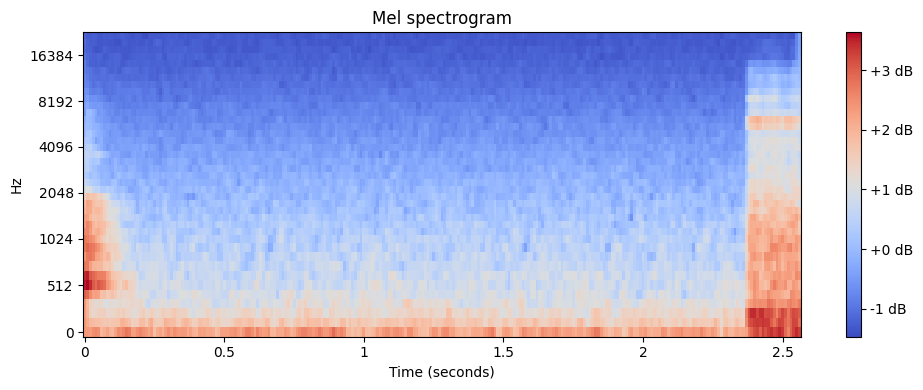

In [27]:
plot_melspectrogram(urbansed_val.audios[11])